In [ ]:
#@title Data Preparation Workflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Change this path if your file is in your Drive, e.g. '/content/drive/MyDrive/path/emotion_data.csv'
data_path = '/content/drive/MyDrive/Emotion_Recognition/data/train/training.csv'
df = pd.read_csv(data_path)

# Display first few rows to get a sense of the data
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3


In [ ]:
# Basic dataset information
print("\nDataset shape:", df.shape)
print("\nDataset info:")
print(df.info())


Dataset shape: (16000, 2)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB
None


In [ ]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
text     0
label    0
dtype: int64


In [ ]:
# Distribution of emotion labels
print("\nEmotion label distribution:")
print(df['label'].value_counts())


Emotion label distribution:
label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64


In [ ]:
# Analyze the text lengths
df['text_length'] = df['text'].apply(len)
print("\nText length descriptive statistics:")
print(df['text_length'].describe())


Text length descriptive statistics:
count    16000.000000
mean        96.845812
std         55.904953
min          7.000000
25%         53.000000
50%         86.000000
75%        129.000000
max        300.000000
Name: text_length, dtype: float64


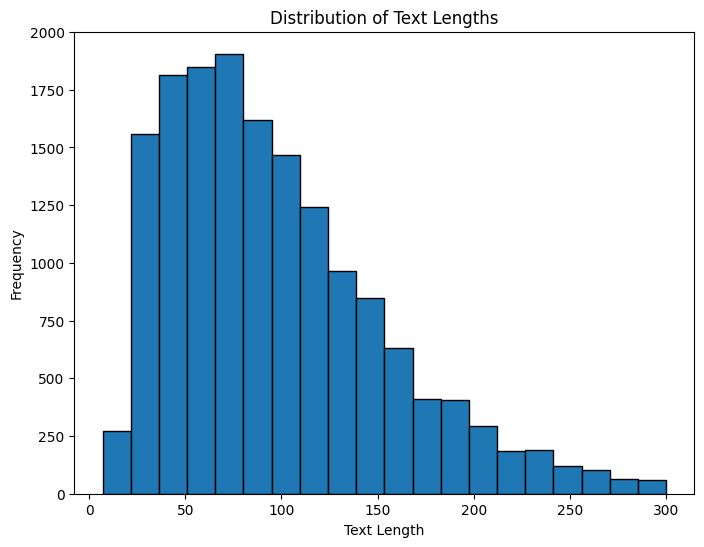

In [ ]:
# Plot the distribution of text lengths
plt.figure(figsize=(8,6))
plt.hist(df['text_length'], bins=20, edgecolor='black')
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Emotion Recognition with LLMs in Google Colab
# Full Implementation with GPU Memory Optimization

# ------------------- SECTION 1: Setup and Config -------------------
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install -q transformers>=4.34.0 datasets>=2.14.0 accelerate>=0.23.0 peft>=0.5.0 scikit-learn>=1.3.0 seaborn>=0.12.0 bitsandbytes>=0.41.0 tqdm

Mounted at /content/drive
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.


In [ ]:
# Create directory structure (uncomment if needed)
import os

# Set the base directory in your Google Drive
base_dir = '/content/drive/MyDrive/Emotion_Recognition'

# Create main directories if they don't exist
directories = [
    'code',
    'code/utils',
    'data',
    'data/train',
    'data/valid',
    'data/test',
    'models',
    'models/mistral',
    'models/llama2',
    'models/llama3',
    'results',
    'results/zero_shot',
    'results/few_shot',
    'results/fine_tuned'
]

for directory in directories:
    os.makedirs(os.path.join(base_dir, directory), exist_ok=True)

# Create __init__.py files if needed
for init_path in [os.path.join(base_dir, 'code/__init__.py'),
                 os.path.join(base_dir, 'code/utils/__init__.py')]:
    if not os.path.exists(init_path):
        with open(init_path, 'w') as f:
            pass

In [ ]:


# ------------------- SECTION 2: GPU Memory Initialization -------------------
import torch
import gc
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import psutil

# Add the code directory to the path
sys.path.append(os.path.join(base_dir, 'code'))

# Check GPU
print("\n===== GPU Information =====")
!nvidia-smi

# Basic GPU setup
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.2f} GB")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU")

# Define GPU Monitor class (copy from gpu_monitor.py)
class GPUMonitor:
    def __init__(self, update_interval=2.0, history_length=60):
        """
        Initialize GPU monitor

        Args:
            update_interval: Time between updates in seconds
            history_length: Number of data points to keep in history
        """
        self.update_interval = update_interval
        self.history_length = history_length

        # Initialize data structures
        self.gpu_memory_used = []
        self.cpu_memory_used = []
        self.timestamps = []

        # Monitoring state
        self.is_monitoring = False
        self.monitor_thread = None

    def _get_gpu_memory_used_gb(self):
        """Get current GPU memory usage in GB"""
        if torch.cuda.is_available():
            return torch.cuda.memory_allocated() / (1024**3)
        return 0.0

    def _get_cpu_memory_used_percent(self):
        """Get current CPU memory usage as percentage"""
        return psutil.virtual_memory().percent

    def _monitor_thread_func(self):
        """Thread function for continuous monitoring"""
        while self.is_monitoring:
            # Get current memory usage
            gpu_mem = self._get_gpu_memory_used_gb()
            cpu_mem = self._get_cpu_memory_used_percent()

            # Add to history
            self.gpu_memory_used.append(gpu_mem)
            self.cpu_memory_used.append(cpu_mem)
            self.timestamps.append(time.time())

            # Trim history if needed
            if len(self.gpu_memory_used) > self.history_length:
                self.gpu_memory_used = self.gpu_memory_used[-self.history_length:]
                self.cpu_memory_used = self.cpu_memory_used[-self.history_length:]
                self.timestamps = self.timestamps[-self.history_length:]

            # Sleep for update interval
            time.sleep(self.update_interval)

    def start(self):
        """Start monitoring"""
        if self.is_monitoring:
            print("Monitoring already running")
            return

        # Reset data
        self.gpu_memory_used = []
        self.cpu_memory_used = []
        self.timestamps = []

        # Start monitoring thread
        self.is_monitoring = True
        self.monitor_thread = threading.Thread(target=self._monitor_thread_func)
        self.monitor_thread.daemon = True
        self.monitor_thread.start()

        print("GPU monitoring started")

    def stop(self):
        """Stop monitoring"""
        if not self.is_monitoring:
            print("Monitoring not running")
            return

        # Stop thread
        self.is_monitoring = False
        if self.monitor_thread:
            self.monitor_thread.join(timeout=1.0)

        print("GPU monitoring stopped")

    def plot(self, clear=True):
        """Plot current GPU and CPU usage"""
        if clear:
            clear_output(wait=True)

        if not self.gpu_memory_used:
            print("No data collected yet")
            return

        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

        # Convert timestamps to relative time in seconds
        relative_times = [t - self.timestamps[0] for t in self.timestamps]

        # Plot GPU memory usage
        ax1.plot(relative_times, self.gpu_memory_used, 'b-')
        ax1.set_title('GPU Memory Usage')
        ax1.set_ylabel('Memory (GB)')

        # Get total GPU memory for reference line
        if torch.cuda.is_available():
            total_gpu_mem = torch.cuda.get_device_properties(0).total_memory / (1024**3)
            ax1.axhline(y=total_gpu_mem, color='r', linestyle='--', label=f'Total GPU Memory ({total_gpu_mem:.2f} GB)')
            ax1.legend()

        # Plot CPU memory usage
        ax2.plot(relative_times, self.cpu_memory_used, 'g-')
        ax2.set_title('CPU Memory Usage')
        ax2.set_ylabel('Usage (%)')
        ax2.set_ylim(0, 100)

        # Set common X axis
        ax2.set_xlabel('Time (seconds)')

        plt.tight_layout()
        plt.show()

        # Print current stats
        if self.gpu_memory_used:
            current_gpu = self.gpu_memory_used[-1]
            current_cpu = self.cpu_memory_used[-1]

            max_gpu = max(self.gpu_memory_used)

            print(f"Current GPU memory: {current_gpu:.2f} GB")
            if torch.cuda.is_available():
                total_gpu_mem = torch.cuda.get_device_properties(0).total_memory / (1024**3)
                print(f"GPU utilization: {current_gpu/total_gpu_mem*100:.2f}% of {total_gpu_mem:.2f} GB")
                print(f"Peak GPU memory: {max_gpu:.2f} GB ({max_gpu/total_gpu_mem*100:.2f}%)")

            print(f"Current CPU memory: {current_cpu:.2f}%")

    def monitor_with_updates(self, duration=60, update_every=10):
        """
        Monitor GPU usage with periodic plot updates

        Args:
            duration: Total monitoring duration in seconds
            update_every: Update plot every N seconds
        """
        # Start monitoring
        self.start()

        # Update plot periodically
        start_time = time.time()
        end_time = start_time + duration

        next_update = start_time + update_every

        try:
            while time.time() < end_time and self.is_monitoring:
                # Check if it's time to update the plot
                current_time = time.time()
                if current_time >= next_update:
                    self.plot()
                    next_update = current_time + update_every

                # Sleep briefly
                time.sleep(0.5)

        except KeyboardInterrupt:
            print("Monitoring interrupted by user")

        finally:
            # Stop monitoring
            self.stop()

            # Final plot
            self.plot()

# Initialize GPU monitor
import threading
monitor = GPUMonitor(update_interval=1.0, history_length=120)

# Function to optimize GPU memory
def optimize_gpu_memory():
    """Optimize GPU memory for large model inference and training"""
    print("\n===== Optimizing GPU Memory =====")

    # Clear PyTorch cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
        print("✓ Cleared PyTorch cache")

    # Set environment variables for memory efficiency
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    print("✓ Disabled tokenizers parallelism")

    # Enable memory efficient attention if available
    if hasattr(torch.nn.functional, 'scaled_dot_product_attention'):
        print("✓ Using PyTorch's memory efficient attention")

    # Print current memory usage
    if torch.cuda.is_available():
        free_mem = torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)
        print(f"Free GPU memory: {free_mem / 1024**3:.2f} GB")

    return

# Optimize memory before starting
optimize_gpu_memory()

# ------------------- SECTION 3: Run Emotion Recognition Experiments -------------------
# Import project modules
import config  # Make sure this is in the code/ directory
from utils.data_loader import load_emotion_dataset, get_few_shot_examples, create_few_shot_prompt, create_zero_shot_prompt
from utils.model_utils import load_base_model, setup_gpu, generate_text
from utils.metrics import parse_llm_output, evaluate_predictions, save_metrics, plot_confusion_matrix, generate_report, save_report

# Verify imports
print(f"Emotion labels: {config.EMOTION_LABELS}")
print(f"Using device configuration: {config.DEVICE_CONFIG}")

# Function to run zero-shot evaluation
def run_zero_shot_with_monitoring(model_name, test_subset_size=None):
    """Run zero-shot evaluation with GPU monitoring"""
    print(f"\n===== Running Zero-Shot Evaluation for {model_name} =====")

    # Start GPU monitoring
    monitor.start()

    try:
        # Optimize memory before loading model
        optimize_gpu_memory()

        # Set up GPU
        device = setup_gpu()

        # Load model
        model_id = config.MODEL_CONFIGS[model_name]["zero_shot"]
        print(f"Loading model: {model_id}")
        model, tokenizer = load_base_model(model_id, is_instruct=True)

        # Load dataset
        print("Loading dataset...")
        datasets = load_emotion_dataset(
            config.TRAIN_PATH,
            config.VALID_PATH,
            config.TEST_PATH
        )

        # Use a subset of the test set if specified
        test_dataset = datasets["test"]
        if test_subset_size is not None and test_subset_size < len(test_dataset):
            test_dataset = test_dataset.select(range(test_subset_size))
            print(f"Using {test_subset_size} examples from test set")
        else:
            print(f"Using all {len(test_dataset)} examples from test set")

        # Check memory usage after loading
        monitor.plot()

        # Initialize containers for true and predicted labels
        true_labels = []
        pred_labels = []

        # Process test examples
        print("Running zero-shot inference...")
        for i, example in enumerate(test_dataset):
            # Create prompt
            prompt = create_zero_shot_prompt(example["text"])

            # Generate response
            response = generate_text(model, tokenizer, prompt, device)

            # Parse prediction
            pred_label = parse_llm_output(response, config.EMOTION_LABELS)

            # Store true and predicted labels
            true_labels.append(example["label"])
            pred_labels.append(pred_label)

            # Periodically check memory and report progress
            if (i + 1) % 10 == 0:
                print(f"Processed {i + 1}/{len(test_dataset)} examples")
                monitor.plot()

        # Evaluate predictions
        print("Evaluating predictions...")
        metrics = evaluate_predictions(true_labels, pred_labels, config.EMOTION_LABELS)

        # Save metrics
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        metrics_file = save_metrics(metrics, model_name, "zero_shot", timestamp)
        print(f"Metrics saved to {metrics_file}")

        # Plot confusion matrix
        if metrics["confusion_matrix"] is not None:
            cm_file = plot_confusion_matrix(
                metrics["confusion_matrix"],
                config.EMOTION_LABELS,
                model_name,
                "zero_shot",
                timestamp
            )
            print(f"Confusion matrix saved to {cm_file}")

        # Generate and save report
        report = generate_report(model_name, "zero_shot", metrics)
        report_file = save_report(report, model_name, "zero_shot", timestamp)
        print(f"Report saved to {report_file}")

        print(f"Zero-shot evaluation for {model_name} completed")

        return metrics

    finally:
        # Stop monitoring
        monitor.stop()
        monitor.plot()

        # Clean up memory
        optimize_gpu_memory()

# Function to run few-shot evaluation
def run_few_shot_with_monitoring(model_name, shots_per_class=3, test_subset_size=None):
    """Run few-shot evaluation with GPU monitoring"""
    print(f"\n===== Running Few-Shot Evaluation for {model_name} =====")

    # Start GPU monitoring
    monitor.start()

    try:
        # Optimize memory before loading model
        optimize_gpu_memory()

        # Set up GPU
        device = setup_gpu()

        # Load model
        model_id = config.MODEL_CONFIGS[model_name]["few_shot"]
        print(f"Loading model: {model_id}")
        model, tokenizer = load_base_model(model_id, is_instruct=True)

        # Load dataset
        print("Loading dataset...")
        datasets = load_emotion_dataset(
            config.TRAIN_PATH,
            config.VALID_PATH,
            config.TEST_PATH
        )

        # Get few-shot examples from training set
        examples_by_class = get_few_shot_examples(
            datasets["train"],
            shots_per_class=shots_per_class
        )

        # Use a subset of the test set if specified
        test_dataset = datasets["test"]
        if test_subset_size is not None and test_subset_size < len(test_dataset):
            test_dataset = test_dataset.select(range(test_subset_size))
            print(f"Using {test_subset_size} examples from test set")
        else:
            print(f"Using all {len(test_dataset)} examples from test set")

        # Check memory usage after loading
        monitor.plot()

        # Initialize containers for true and predicted labels
        true_labels = []
        pred_labels = []

        # Process test examples
        print("Running few-shot inference...")
        for i, example in enumerate(test_dataset):
            # Create prompt with few-shot examples
            prompt = create_few_shot_prompt(examples_by_class, example["text"])

            # Generate response
            response = generate_text(model, tokenizer, prompt, device)

            # Parse prediction
            pred_label = parse_llm_output(response, config.EMOTION_LABELS)

            # Store true and predicted labels
            true_labels.append(example["label"])
            pred_labels.append(pred_label)

            # Periodically check memory and report progress
            if (i + 1) % 10 == 0:
                print(f"Processed {i + 1}/{len(test_dataset)} examples")
                monitor.plot()

        # Evaluate predictions
        print("Evaluating predictions...")
        metrics = evaluate_predictions(true_labels, pred_labels, config.EMOTION_LABELS)

        # Save metrics
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        metrics_file = save_metrics(metrics, model_name, "few_shot", timestamp)
        print(f"Metrics saved to {metrics_file}")

        # Plot confusion matrix
        if metrics["confusion_matrix"] is not None:
            cm_file = plot_confusion_matrix(
                metrics["confusion_matrix"],
                config.EMOTION_LABELS,
                model_name,
                "few_shot",
                timestamp
            )
            print(f"Confusion matrix saved to {cm_file}")

        # Generate and save report
        report = generate_report(model_name, "few_shot", metrics)
        report_file = save_report(report, model_name, "few_shot", timestamp)
        print(f"Report saved to {report_file}")

        print(f"Few-shot evaluation for {model_name} completed")

        return metrics

    finally:
        # Stop monitoring
        monitor.stop()
        monitor.plot()

        # Clean up memory
        optimize_gpu_memory()

# Run comparison across models
def run_model_comparison(experiment_type, models=["mistral", "llama2", "llama3"], subset_size=50):
    """Run comparison of different models"""
    results = {}

    for model in models:
        print(f"\n======= Running {experiment_type} for {model} =======\n")

        if experiment_type == "zero_shot":
            results[model] = run_zero_shot_with_monitoring(model, test_subset_size=subset_size)
        elif experiment_type == "few_shot":
            results[model] = run_few_shot_with_monitoring(model, shots_per_class=3, test_subset_size=subset_size)
        else:
            print(f"Unknown experiment type: {experiment_type}")
            continue

    # Compare results
    print("\n======= Comparison =======\n")
    print("| Model | Accuracy | Precision | Recall | F1 |")
    print("|-------|----------|-----------|--------|-----|")
    for model, metrics in results.items():
        print(f"| {model} | {metrics['accuracy']:.4f} | {metrics['precision']:.4f} | {metrics['recall']:.4f} | {metrics['f1']:.4f} |")

    return results



===== GPU Information =====
Tue Apr 15 03:07:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   32C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------

In [ ]:
# Option 1: Run zero-shot for one model
model_name = "llama2"  # Choose from: "mistral", "llama2", "llama3"
test_subset_size = None  # Set to None to use full test set
metrics = run_zero_shot_with_monitoring(model_name, test_subset_size)



In [ ]:
# Option 1: Run zero-shot for one model
model_name = "llama2"  # Choose from: "mistral", "llama2", "llama3"
test_subset_size = None  # Set to None to use full test set
metrics = run_zero_shot_with_monitoring(model_name, test_subset_size)



In [ ]:
# Option 1: Run zero-shot for one model
model_name = "llama3"  # Choose from: "mistral", "llama2", "llama3"
test_subset_size = None  # Set to None to use full test set
metrics = run_zero_shot_with_monitoring(model_name, test_subset_size)



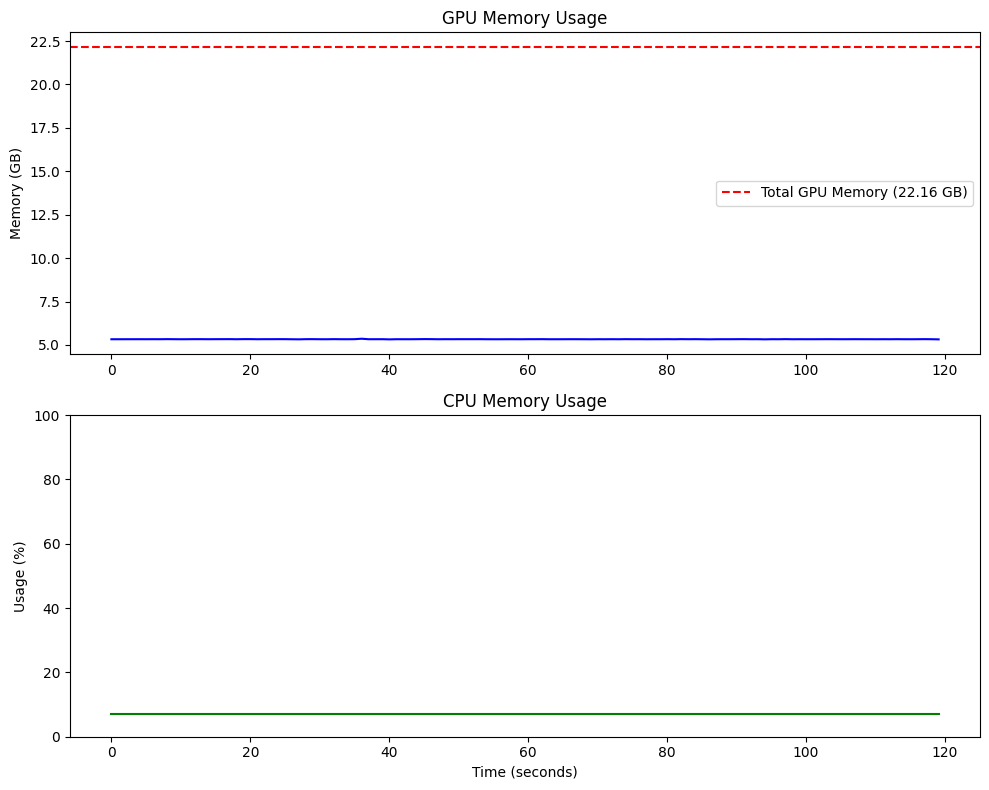

Current GPU memory: 5.32 GB
GPU utilization: 24.01% of 22.16 GB
Peak GPU memory: 5.36 GB (24.18%)
Current CPU memory: 7.10%

===== Optimizing GPU Memory =====
✓ Cleared PyTorch cache
✓ Disabled tokenizers parallelism
✓ Using PyTorch's memory efficient attention
Free GPU memory: 16.84 GB


In [ ]:
# Option 2: Run few-shot for one model
model_name = "mistral"  # Choose from: "mistral", "llama2", "llama3"
shots_per_class = 3
test_subset_size = None  # Set to None to use full test set
metrics = run_few_shot_with_monitoring(model_name, shots_per_class, test_subset_size)



In [ ]:
# Option 2: Run few-shot for one model
model_name = "llama2"  # Choose from: "mistral", "llama2", "llama3"
shots_per_class = 3
test_subset_size = None  # Set to None to use full test set
metrics = run_few_shot_with_monitoring(model_name, shots_per_class, test_subset_size)



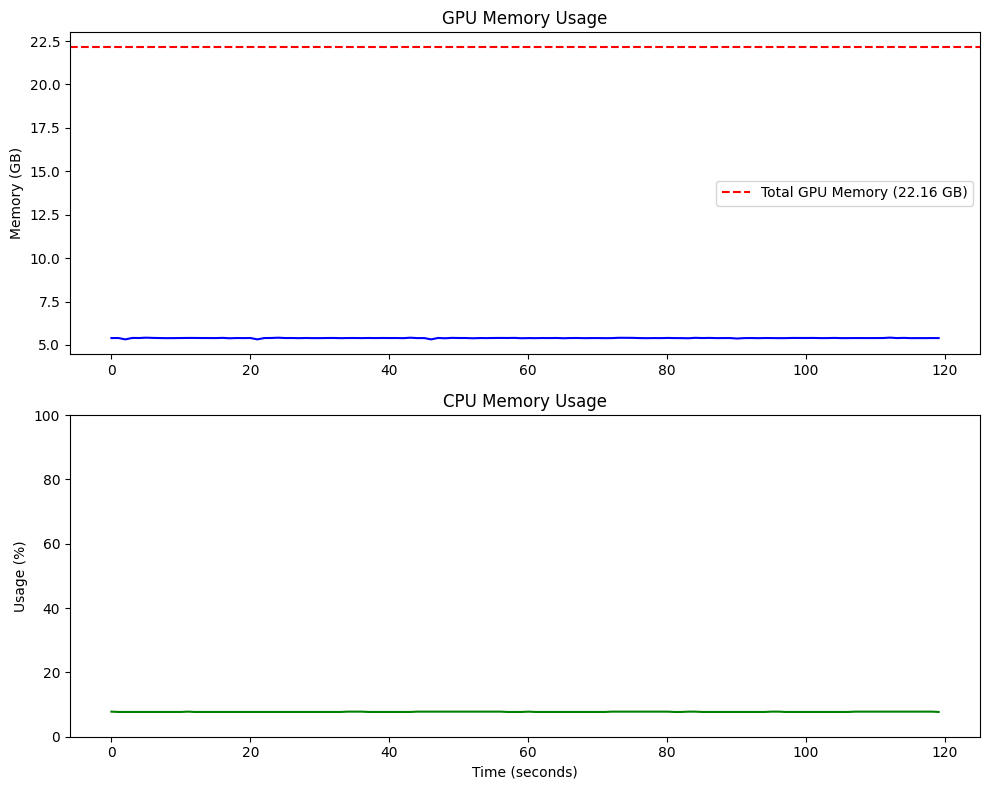

Current GPU memory: 5.40 GB
GPU utilization: 24.35% of 22.16 GB
Peak GPU memory: 5.42 GB (24.47%)
Current CPU memory: 7.70%

===== Optimizing GPU Memory =====
✓ Cleared PyTorch cache
✓ Disabled tokenizers parallelism
✓ Using PyTorch's memory efficient attention
Free GPU memory: 16.84 GB


In [ ]:
# Option 2: Run few-shot for one model
model_name = "llama3"  # Choose from: "mistral", "llama2", "llama3"
shots_per_class = 3
test_subset_size = None  # Set to None to use full test set
metrics = run_few_shot_with_monitoring(model_name, shots_per_class, test_subset_size)

